In [ ]:
# getting all of the stocks in the US
import investpy
import yfinance as yf
import pandas as pd
import pytz



In [ ]:
# Get list of all stocks in the US
stocks = investpy.stocks.get_stocks(country='united states')
russel = pd.read_csv("russel1000.csv")
russel_tick = russel['Ticker'].to_list()


In [ ]:
# getting the dividend data for the above stocks


def get_dividend_data(tickers):
    """
    Fetches dividend data and calculates dividend yield for a list of tickers over the past 5 years.

    Parameters:
    tickers (list): List of stock tickers.

    Returns:
    pd.DataFrame: DataFrame with columns 'Date', 'Ticker', 'Dividend', 'Stock Price', and 'Dividend Yield (%)'.
    """
    all_dividends = []

    for ticker in tickers:
        #print(f"Fetching data for {ticker}")
        try:
            stock = yf.Ticker(ticker)
            dividends = stock.dividends
            stock_prices = stock.history(period="5y")['Close']  # Get past 5 years of stock price data
        except:
            print(f"Failed to fetch data for {ticker}")
            continue

        if dividends.empty:
            print(f"No dividend data for {ticker}")
            continue

        # Create a dataframe for dividends
        df = pd.DataFrame({
            'Date': dividends.index,
            'Ticker': ticker,
            'Dividend': dividends.values
        })

        # Fetch stock price at the closest available date before or on dividend date
        df['Stock Price'] = df['Date'].apply(lambda x: stock_prices.loc[:x].iloc[-2] if len(stock_prices.loc[:x]) > 1 else None)

        # Calculate Dividend Yield (%)
        df['Dividend Yield (%)'] = (df['Dividend'] / df['Stock Price']) * 100

        all_dividends.append(df)

    if all_dividends:
        result = pd.concat(all_dividends, ignore_index=True)
        result.sort_values(by='Date', inplace=True)
        return result.reset_index(drop=True)
    else:
        print("No dividends found for any ticker.")
        return pd.DataFrame(columns=['Date', 'Ticker', 'Dividend', 'Stock Price', 'Dividend Yield (%)'])

# Example usage:
#tickers = stocks['symbol'].to_list()
#df = get_dividend_data(russel_tick)

stocks = pd.read_csv('penny_stocks.csv')
tickers = stocks['Symbol'].to_list()
df = get_dividend_data(tickers)

In [ ]:
#df.to_csv('russel1000_dividend_last5years.csv')
df.to_csv('penny_stocks_dividend_last5years.csv')

In [ ]:
#df = pd.read_csv('russel1000_dividend_last5years.csv')
df.dropna(inplace=True)
df.sort_values(by='Date', ascending=False, inplace=True)
df

In [ ]:
# computing the last year dividend
df["Date"] = pd.to_datetime(df["Date"])

# Define the date range for filtering
start_date = "2024-02-17"
end_date = "2025-05-17"

# Filter data for the last year
df_filtered = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]

# Group by Ticker and sum Dividend Yield (%) for the last year
df_grouped = df_filtered.groupby("Ticker", as_index=False).agg(
    {"Dividend Yield (%)": "sum"}
)

# Rename the column to "Last year Dividend Yield (%)"
df_grouped.rename(columns={"Dividend Yield (%)": "Last year Dividend Yield (%)"}, inplace=True)

# Merge back with the original df to retain all tickers
df = df.merge(df_grouped, on="Ticker", how="left")

# Fill NaN with 0 for tickers with no dividends in the date range
df["Last year Dividend Yield (%)"].fillna(0, inplace=True)

In [ ]:
# sorted list of the last year dividend
import heapq
Threshold = 20
stack = []
heapq.heapify(stack)
df.sort_values(by='Last year Dividend Yield (%)', ascending=False, inplace=True)
for gr, gr_df in df.groupby("Ticker"):
    gr_df.reset_index(drop=True, inplace=True)
    gr_df.sort_values(by="Date", ascending=True, inplace=True)
    dividend = gr_df.loc[0, 'Last year Dividend Yield (%)']
    if dividend > Threshold:
        heapq.heappush(stack, (-dividend, gr, gr_df))

In [ ]:
len(stack)

In [ ]:
# balance sheet extractor
# pip install edgartools
import sys
from edgar import *
from edgar.financials import Financials
import pandas as pd

set_identity("sarashs arash.sheikh65@gmail.com")

from edgar import Company

def fetch_10K_and_10Q_filings(ticker: str, start_date: str, end_date: str, form: list = ['10-K']):
    """
    Fetches the 10-K and 10-Q filings for the given ticker within the specified date range.

    Note:
      - Make sure you have set your EDGAR identity (using set_identity) before calling this function.
      - The date filter should be in the form "YYYY-MM-DD:YYYY-MM-DD".

    Parameters:
        ticker (str): The stock ticker (e.g., "AAPL").
        start_date (str): The start date in "YYYY-MM-DD" format.
        end_date (str): The end date in "YYYY-MM-DD" format.

    Returns:
        list: A list-like object of filing objects (or an empty list if no filings are found).
    """
    try:
        # Create a Company object for the given ticker
        company = Company(ticker)
        # Retrieve both 10-K and 10-Q filings for the company
        filings = company.get_filings(form=form) #"10-K",
        # Filter the filings based on the provided date range
        # The filter date string uses the format "start_date:end_date"
        filtered_filings = filings.filter(date=f"{start_date}:{end_date}")
        
        if not filtered_filings:
            print(f"No 10-K or 10-Q filings found for {ticker} between {start_date} and {end_date}.")
            return []
            
        return filtered_filings

    except Exception as e:
        print(f"An error occurred while fetching filings for {ticker}: {e}")
        return []


def extract_financials(filings):
    """
    Extracts financial statements from a list of filings.
    
    For each filing, the function:
      - Calls filing.obj() to get the data object (e.g. TenK/TenQ).
      - Checks that the object has a 'financials' attribute.
      - Extracts the balance sheet, income statement, and cashflow statement using:
            financials.get_balance_sheet()
            financials.get_income_statement()
            financials.get_cash_flow_statement()
    
    Parameters:
        filings (list): A list-like object of filing objects (e.g. from Company.get_filings()).
    
    Returns:
        tuple: Six items containing the extracted financial statements:
               (balance_sheets, income_statements, cashflow_statements, 
                balance_sheets_str, income_statements_str, cashflow_statements_str).
               Filings that do not have a data object or the requested financial statement(s) are skipped.
    """
    balance_sheets = []
    income_statements = []
    cashflow_statements = []
    
    for filing in filings:
        try:
            # Convert the filing to its data object (e.g., TenK or TenQ)
            data_obj = filing.obj()
            if data_obj is None:
                print("Filing has no data object. Skipping...")
                continue
            
            # Check that the data object contains financials
            if not hasattr(data_obj, "financials") or data_obj.financials is None:
                print("Filing has no financials. Skipping...")
                continue

            financials = data_obj.financials
            
            # Extract the individual financial statements.
            # If any of these methods are unavailable or return None, skip that particular statement.
            balance_sheet = financials.get_balance_sheet() if hasattr(financials, "get_balance_sheet") else None
            income_statement = financials.get_income_statement() if hasattr(financials, "get_income_statement") else None
            cashflow_statement = financials.get_cash_flow_statement() if hasattr(financials, "get_cash_flow_statement") else None
            
            if balance_sheet is not None:
                balance_sheets.append(balance_sheet)
            if income_statement is not None:
                income_statements.append(income_statement)
            if cashflow_statement is not None:
                cashflow_statements.append(cashflow_statement)
        
        except Exception as e:
            print(f"Error extracting financials from filing: {e}")
            continue

    # Convert to structured strings for LLM processing with enhanced metadata
    def format_statement_for_llm(statement, statement_type, index):
        parts = []
        parts.append(f"=== {statement_type} {index + 1} ===")
        
        # Add metadata if available
        if hasattr(statement, 'period_end_date'):
            parts.append(f"Period End Date: {statement.period_end_date}")
        if hasattr(statement, 'filing_date'):
            parts.append(f"Filing Date: {statement.filing_date}")
        if hasattr(statement, 'period_focus'):
            parts.append(f"Period Focus: {statement.period_focus}")
        if hasattr(statement, 'fiscal_year'):
            parts.append(f"Fiscal Year: {statement.fiscal_year}")
        if hasattr(statement, 'fiscal_period'):
            parts.append(f"Fiscal Period: {statement.fiscal_period}")
        
        parts.append("")  # Empty line before data
        
        # Use to_dataframe() but with better formatting
        df = statement.to_dataframe()
        if not df.empty:
            # Round numeric values for cleaner display
            df_display = df.copy()
            for col in df_display.select_dtypes(include=['float64', 'int64']).columns:
                df_display[col] = df_display[col].apply(lambda x: f"{x:,.0f}" if pd.notna(x) else "")
            parts.append(df_display.to_string())
        else:
            parts.append("No data available")
        
        return '\n'.join(parts)
    
    balance_sheet_parts = [format_statement_for_llm(item, "BALANCE SHEET", i) 
                          for i, item in enumerate(balance_sheets)]
    balance_sheets_str = '\n\n'.join(balance_sheet_parts)
    
    income_statement_parts = [format_statement_for_llm(item, "INCOME STATEMENT", i) 
                             for i, item in enumerate(income_statements)]
    income_statements_str = '\n\n'.join(income_statement_parts)
    
    cashflow_statement_parts = [format_statement_for_llm(item, "CASH FLOW STATEMENT", i) 
                               for i, item in enumerate(cashflow_statements)]
    cashflow_statements_str = '\n\n'.join(cashflow_statement_parts)
    
    return balance_sheets, income_statements, cashflow_statements, balance_sheets_str, income_statements_str, cashflow_statements_str

#test
filings_list = fetch_10K_and_10Q_filings("nvda", "2023-01-01", "2025-2-15",form=["10-Q", "10-K"])
balance_sheets, income_statements, cashflow_statements, balance_sheets_str, income_statements_str, cashflow_statements_str = extract_financials(filings_list)#

In [121]:
# Example usage:
filings_list = fetch_10K_and_10Q_filings("RCM", "2023-01-01", "2025-2-15",form=["10-Q", "10-K"]) # SHOP CRWD
balance_sheets, income_statements, cashflow_statements, balance_sheets_str, income_statements_str, cashflow_statements_str = extract_financials(filings_list)


In [105]:
# Open ai financial health assessment

from pydantic import BaseModel
from openai import OpenAI

client = OpenAI()

class Step(BaseModel):
    justification: str

class Assessment(BaseModel):
    steps: list[Step]
    trends: str
    approve: bool
    
def assess(income_statements_str, cashflow_statements_str, balance_sheets_str):
    completion = client.beta.chat.completions.parse(
        model="o3-mini",
        reasoning_effort= "high",
        messages=[
            {"role": "system", "content": """You are a financial advisor. You are provided the last two years worth of financial data based on 10-K and 10-K documnent for a company.
            The goal is to buy the most promising dividend stock. Whether or not a stock is a dividend stock is not for you to extract but you are looking at the financial health of the company and your primary goal is to avoid risk.
            You must provide me with the trends over the past two years, your step by step justification of your assessment and whether or not you approve this purchase considering the potential risks to this company."""},
            {"role": "user", "content": f"""Here are the balance sheets, income statements, and cashflow statements for the past three years.\n\n
            Income statements:\n{income_statements_str}\n\nCashflow statements:\n{cashflow_statements_str}\n\nBalance sheets:\n{balance_sheets_str}
            """},
        ],
        response_format=Assessment,
    )
    
    assessment = completion.choices[0].message.parsed
    return assessment

In [106]:
from pprint import pp

In [107]:
# processing the balance sheets
from tqdm import tqdm
balance_sheet_approved = {}
balance_sheet_rejected = {}
for i in tqdm(range(len(stack))):
    try:
        dividend, gr, gr_df = stack[i]
        filings_list = fetch_10K_and_10Q_filings(gr, "2023-01-01", "2025-5-15",form=["10-Q", "10-K"])
        _, _, _, balance_sheets_str, income_statements_str, cashflow_statements_str = extract_financials(filings_list)
        assessment = assess(income_statements_str, cashflow_statements_str, balance_sheets_str)
        if assessment.approve:
            balance_sheet_approved[gr] = (dividend, assessment.trends, gr_df)
        else:
            balance_sheet_rejected[gr] = (dividend, assessment.trends, gr_df)
    except Exception as e:
        print(e)
    

NameError: name 'stack' is not defined

In [108]:
import pickle

with open('investment_grade_dividend_penny_stocks.pkl', 'wb') as f:
    pickle.dump(balance_sheet_approved, f)

In [109]:
balance_sheet_rejected

{}

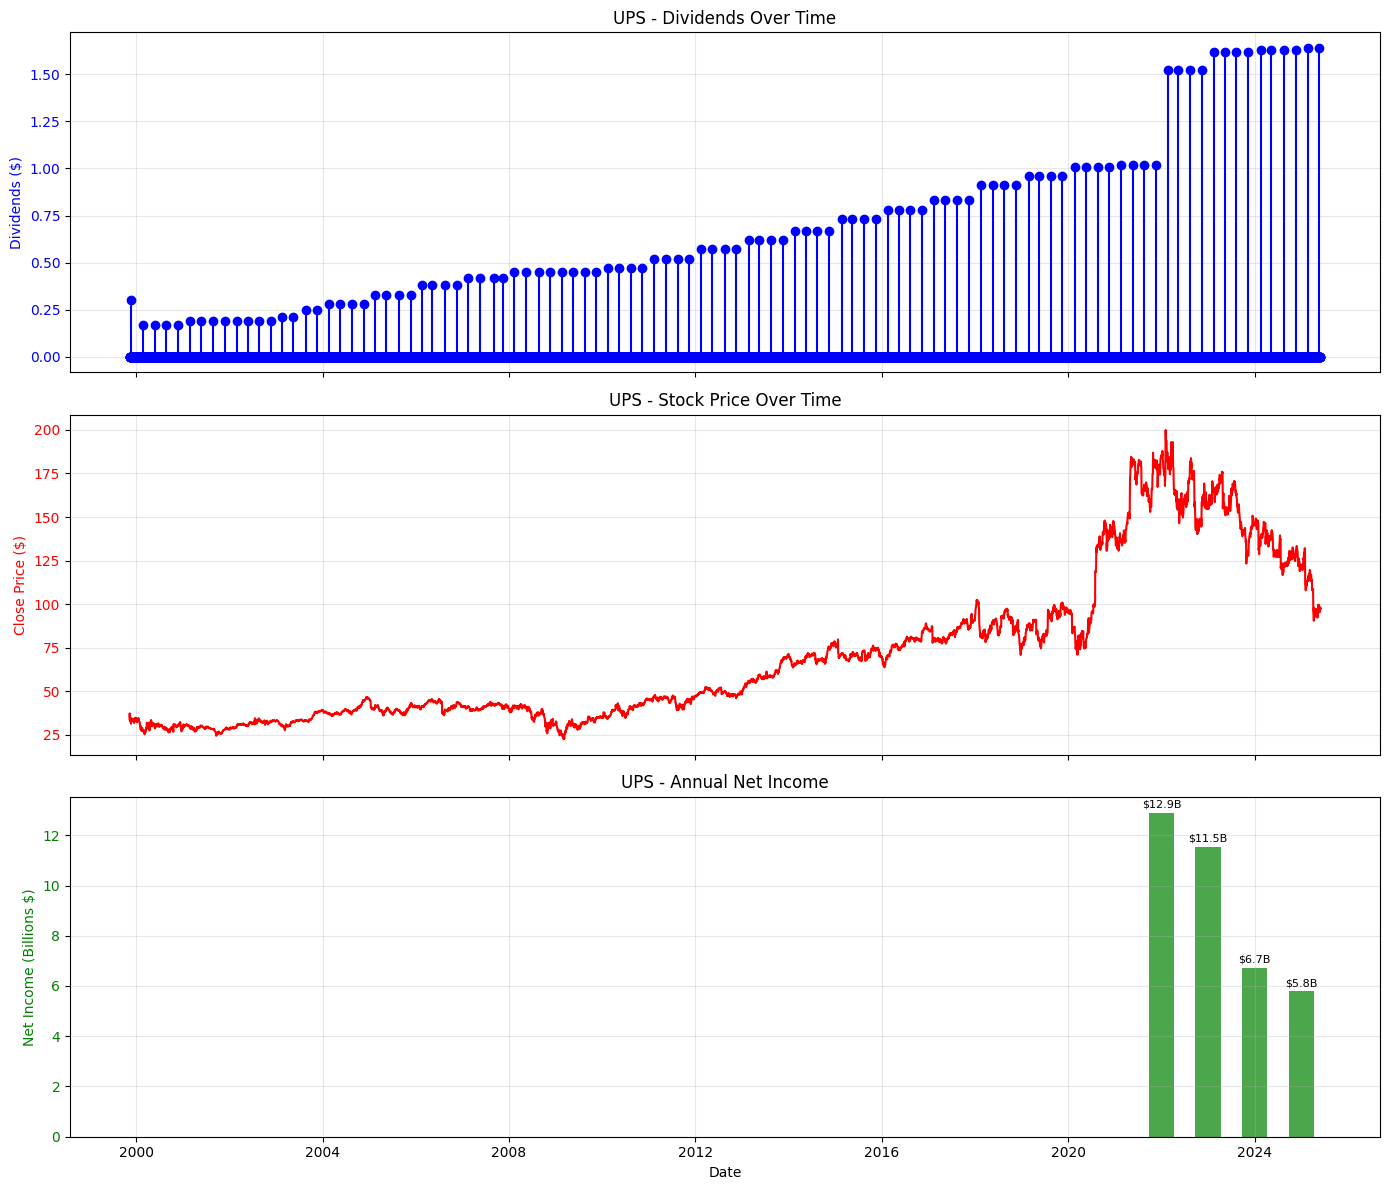


=== UPS Summary Statistics ===
Dividend Stats:
  Total Dividends Paid: 71.38
  Average Dividend: 0.69
  Latest Dividend: 1.64

Price Stats:
  Current Price: $97.54
  52-Week High: $199.94
  52-Week Low: $22.61

Net Income Stats:
  Latest Net Income: $12.9B
  Average Net Income: $9.2B


In [23]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

ticker = 'UPS'#'CIG' 'KO' 'O' 'UPBD', 'M'

# Initialize DataFrames to store data
all_dividends = pd.DataFrame()
all_prices = pd.DataFrame()
stock = yf.Ticker(ticker)

# Get dividend history
dividends = stock.dividends.reset_index()
dividends['Ticker'] = ticker

# Get historical price data
prices = stock.history(period="max").reset_index()[['Date', 'Close']]
prices['Ticker'] = ticker

# Get financial data (includes net income)
try:
    # Get annual financials
    financials = stock.financials
    # Net income is typically in the first row
    net_income = financials.loc['Net Income'] if 'Net Income' in financials.index else None
    
    # If Net Income not found, try alternative names
    if net_income is None:
        for possible_name in ['Total Revenue', 'Revenue', 'Net Income Common Stockholders']:
            if possible_name in financials.index:
                net_income = financials.loc[possible_name]
                break
    
    if net_income is not None:
        # Convert to DataFrame and reset index
        net_income_df = net_income.reset_index()
        net_income_df.columns = ['Date', 'Net_Income']
        net_income_df['Net_Income'] = net_income_df['Net_Income'] / 1e9  # Convert to billions
        net_income_df.set_index('Date', inplace=True)
    else:
        net_income_df = pd.DataFrame()
        
except Exception as e:
    print(f"Warning: Could not fetch financial data: {e}")
    net_income_df = pd.DataFrame()

# Append to the main DataFrames
all_dividends = pd.concat([all_dividends, dividends], ignore_index=True)
all_prices = pd.concat([all_prices, prices], ignore_index=True)

# Set the date as the index
all_dividends.set_index('Date', inplace=True)
all_prices.set_index('Date', inplace=True)

div_data = all_dividends[all_dividends['Ticker'] == ticker]
price_data = all_prices[all_prices['Ticker'] == ticker]

# Aligning the indices to ensure proper plotting
combined_data = pd.merge(price_data, div_data[['Dividends']], left_index=True, right_index=True, how='outer')

# Create the plot with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot 1: Dividends
ax1.stem(combined_data.index, combined_data['Dividends'].fillna(0), 
         linefmt='blue', markerfmt='bo', basefmt=" ", label='Dividends')
ax1.set_ylabel('Dividends ($)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title(f'{ticker} - Dividends Over Time')
ax1.grid(True, alpha=0.3)

# Plot 2: Stock Price
ax2.plot(combined_data.index, combined_data['Close'], color='red', linewidth=1.5, label='Close Price')
ax2.set_ylabel('Close Price ($)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_title(f'{ticker} - Stock Price Over Time')
ax2.grid(True, alpha=0.3)

# Plot 3: Net Income (if available)
if not net_income_df.empty:
    ax3.bar(net_income_df.index, net_income_df['Net_Income'], 
            color='green', alpha=0.7, width=200, label='Net Income')
    ax3.set_ylabel('Net Income (Billions $)', color='green')
    ax3.tick_params(axis='y', labelcolor='green')
    ax3.set_title(f'{ticker} - Annual Net Income')
    ax3.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for date, value in zip(net_income_df.index, net_income_df['Net_Income']):
        ax3.text(date, value + (max(net_income_df['Net_Income']) * 0.01), 
                f'${value:.1f}B', ha='center', va='bottom', fontsize=8)
else:
    ax3.text(0.5, 0.5, 'Net Income data not available', 
             transform=ax3.transAxes, ha='center', va='center', fontsize=12)
    ax3.set_title(f'{ticker} - Net Income (Data Not Available)')

ax3.set_xlabel('Date')

# Adjust layout and show
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n=== {ticker} Summary Statistics ===")
print(f"Dividend Stats:")
print(f"  Total Dividends Paid: {div_data['Dividends'].sum():.2f}")
print(f"  Average Dividend: {div_data['Dividends'].mean():.2f}")
print(f"  Latest Dividend: {div_data['Dividends'].iloc[-1]:.2f}" if not div_data.empty else "  No dividend data")

print(f"\nPrice Stats:")
print(f"  Current Price: ${price_data['Close'].iloc[-1]:.2f}" if not price_data.empty else "  No price data")
print(f"  52-Week High: ${price_data['Close'].max():.2f}" if not price_data.empty else "")
print(f"  52-Week Low: ${price_data['Close'].min():.2f}" if not price_data.empty else "")

if not net_income_df.empty:
    print(f"\nNet Income Stats:")
    print(f"  Latest Net Income: ${net_income_df['Net_Income'].iloc[-1]:.1f}B")
    print(f"  Average Net Income: ${net_income_df['Net_Income'].mean():.1f}B")